# Linear Regression using stock market data and stock technical indicators

This is a simple example using Linear Regression to predict stock prices. Stock data is loaded from the web using pandas datareader, a few features are added, and predictions are made using Linear Regression.

Secondly, multiple features are added (although not throughly thought out) by calculating technical indicators using TA-Lib. Normally this is not recommended as it leads to overfitting (and quite possibly just creating a lot of noise).

When time permits, I will dive deeper into the technical indicators, apply them properly, and use backward elimination to find those that add value to the model.

In [21]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np
import warnings
import datetime
from datetime import datetime as dt, timedelta
import time
warnings.filterwarnings('ignore')

# machine learning...
from sklearn import preprocessing, svm, cross_validation
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# visualization...
import matplotlib 
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from matplotlib.finance import candlestick_ohlc
import matplotlib.dates as mdates

# to calculate technical indicators
import talib
from talib.abstract import *

matplotlib.style.use('ggplot')
import sys

## Load open, high, low, close data for Apple

Load data for Apple using pandas datareader (Investors Exchange data)
 - more info: http://pandas-datareader.readthedocs.io/en/latest/remote_data.html#remote-data-iex

In [2]:
ticker = "AAPL"
start = dt.today() - timedelta(days=5*365)
end = dt.now()

df = web.DataReader(ticker, 'iex', start, end) 

# convert index to datetime...
df.index = pd.to_datetime(df.index)

df.info()
df.tail()
df.index

5y
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1258 entries, 2013-06-21 to 2018-06-19
Data columns (total 5 columns):
open      1258 non-null float64
high      1258 non-null float64
low       1258 non-null float64
close     1258 non-null float64
volume    1258 non-null int64
dtypes: float64(4), int64(1)
memory usage: 59.0 KB


DatetimeIndex(['2013-06-21', '2013-06-24', '2013-06-25', '2013-06-26',
               '2013-06-27', '2013-06-28', '2013-07-01', '2013-07-02',
               '2013-07-03', '2013-07-05',
               ...
               '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-11',
               '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15',
               '2018-06-18', '2018-06-19'],
              dtype='datetime64[ns]', name='date', length=1258, freq=None)

## Display as candlestick

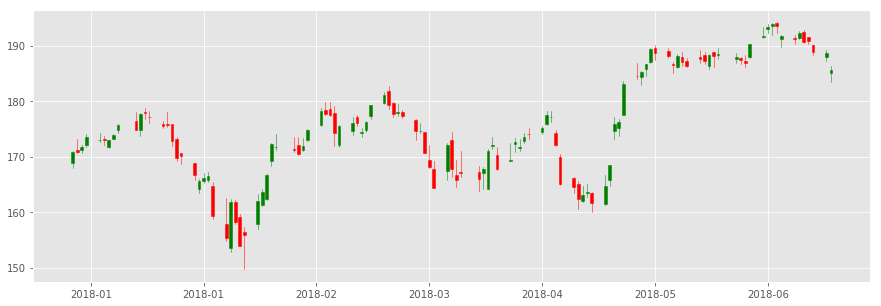

In [3]:
# pull date out of index and convert
df['date']= matplotlib.dates.date2num(df.index.to_pydatetime())

# plot from beginning of year...
start = matplotlib.dates.datestr2num('2018-01-01')

# dataframe to plot
ohlc =  df[['date','open','high','low','close']][df.date > start]
f1, ax = plt.subplots(figsize = (15,5))

# plot the candlesticks
candlestick_ohlc(ax, ohlc.values, width=.6, colorup='green', colordown='red')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.show()

# drop date column used for plot
df = df.drop('date', axis=1)

## Add a few Features to the data (later we'll add plenty more!)

In [5]:
# high low %...
df['highlow_pct'] = (df['high'] - df['low']) / (df['low']*100)

# percent change...
df['pct_change'] = (df['close'] - df['open']) / (df['open']*100)

# return...
df['return']  =np.log(df['open'] / df['open'].shift(1))
df.dropna(inplace=True)

## Prepare the data for classification
- set the target column (dependant variable)
- how many days forward to predict

Next, add a new column target_close that contains the close price n days into the future (n=prediction_days)


#### Feature Matrix
create a feature matrix with all the columns except target_close and scale the data

In [6]:
# predict 10 days out
prediction_days = 10

In [7]:
df.columns

Index(['open', 'high', 'low', 'close', 'volume', 'highlow_pct', 'pct_change',
       'return'],
      dtype='object')

### Get features (except for last 10 days - what we are trying to predict)

In [8]:
X = np.array(df.drop(df.index[len(df)-10]))
X_forecast = X[-prediction_days:]
X = X[:-prediction_days]

Set y to the close -10 day (this is what the model will predict)

In [9]:
y = df['close'].shift(-prediction_days)
y.drop(y.index[len(y)-prediction_days], inplace=True)
y = np.array(y)
y = y[:-prediction_days]

In [10]:
print('Lenght of x, y', len(X), len(y))

Lenght of x, y 1246 1246


### Create Test and Train sets
Use Cross validation to split into test and train data)

In [11]:
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X, y, test_size = 0.2)

print('length of X_train and x_test: ', len(X_train), len(X_test))

length of X_train and x_test:  996 250


## Classify with Linear Regression

In [12]:
clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)

Accuracy of Linear Regression:  0.969613106314


## Predict the last 10 days

In [13]:
result = df.ix[-prediction_days:]  

# save last 30 days predictions
result['Predicted'] =  clf.predict(X_forecast)

print(df.ix[-prediction_days:]['close'])
print('Predicted Close',clf.predict(X_forecast))

date
2018-06-06    193.98
2018-06-07    193.46
2018-06-08    191.70
2018-06-11    191.23
2018-06-12    192.28
2018-06-13    190.70
2018-06-14    190.80
2018-06-15    188.84
2018-06-18    188.74
2018-06-19    185.69
Name: close, dtype: float64
Predicted Close [ 192.46032382  192.29340719  190.84445991  190.43799626  191.4160666
  191.12813336  189.37094356  187.88340278  188.3781452   185.74032022]


# Plot the predictions with the actual close

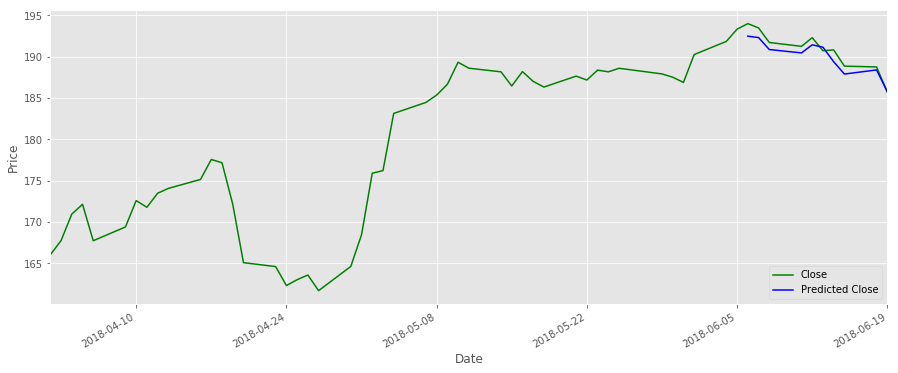

In [14]:
df['20180401':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green", label='Close') 
result['Predicted'].plot(figsize=(15,6), color="blue", label='Predicted Close') 

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

# Further Feature Engineering
### Technical Analysis Indicators
Now, brute force a bunch of stock indicators as features and re-classify.  Normally you would apply domain knowledge to properly setup each indicator and then go through the process of features elimination, but in order to save time lets just plow in a bunch of indicators to see if the prediction improves.

Indicators were generated using TA-Lib (https://mrjbq7.github.io/ta-lib/).  In all cases the defaults were used for all functions.

### Function to generate features

In [15]:
# Overlap Studies Functions
bb = BBANDS(df, timeperiod=5, nbdevup=2, nbdevdn=2, matype=0)
df['bbup'] = bb.upperband
df['bbmid'] = bb.middleband
df['bblow'] = bb.lowerband
df['DEMA'] = DEMA(df, timeperiod=30)
df['EMA'] = EMA(df, timeperiod=30)
df['HT_TRENDLINE'] = HT_TRENDLINE(df)
df['KAMA'] = KAMA(df, timeperiod=30)
df['MA'] = MA(df, timeperiod=30, matype=0)
df['MIDPOINT'] = MIDPOINT(df, timeperiod=14)
df['MIDPRICE'] = MIDPRICE(df, timeperiod=14)
df['SAR'] = SAR(df, acceleration=0, maximum=0)
df['SAREXT'] = SAREXT(df, startvalue=0, offsetonreverse=0, accelerationinitlong=0, accelerationlong=0, accelerationmaxlong=0, accelerationinitshort=0, accelerationshort=0, accelerationmaxshort=0)
df['SMA'] = SMA(df, timeperiod=30)
df['T3'] = T3(df, timeperiod=5, vfactor=0)
df['TEMA'] = TEMA(df, timeperiod=30)
df['TRIMA'] = TRIMA(df, timeperiod=30)
df['WMA'] = WMA(df, timeperiod=30)
#
# Momentum Indicator Functions
#
df['ADX'] = ADX(df, timeperiod=14)
df['APO'] = APO(df, fastperiod=12, slowperiod=26, matype=0)
dftemp = AROON(df, timeperiod=14)
df['AroonDown'] = dftemp.aroondown
df['AroonUp'] = dftemp.aroonup
df['AroonOsc'] = AROONOSC(df, timeperiod=14)
df['BOP'] = BOP(df)
df['CCI'] = CCI(df, timeperiod=14)
df['CMO'] = CMO(df, timeperiod=14)
df['DX'] = DX(df, timeperiod=14)
dftemp =  MACDFIX(df, signalperiod=9)
df['MACD'] = dftemp.macd
df['MACDsignal'] = dftemp.macdsignal
df['MACDhist'] = dftemp.macdhist
df['MINUS_DI'] = MINUS_DI(df, timeperiod=14)
df['MINUS_DM'] = MINUS_DM(df, timeperiod=14)
df['PLUS_DI'] = PLUS_DI(df, timeperiod=14)
df['PLUS_DM'] = PLUS_DM(df, timeperiod=14)
df['PPO'] = PPO(df, fastperiod=12, slowperiod=26, matype=0)
df['ROC'] = ROC(df, timeperiod=10)
df['ROCP'] = ROCP(df, timeperiod=10)
df['ROCR'] = ROCR(df, timeperiod=10)
df['ROCR100'] = ROCR100(df, timeperiod=10)
df['RSI'] = RSI(df, timeperiod=14)
dftemp = STOCH(df, fastk_period=5, slowk_period=3, slowk_matype=0, slowd_period=3, slowd_matype=0)
df['slowk'] = dftemp.slowk
df['slowd'] = dftemp.slowd
dftemp = STOCHF(df, fastk_period=5, fastd_period=3, fastd_matype=0)
df['fastk'] = dftemp.fastk
df['fastd'] = dftemp.fastd
df['ULTOSC'] = ULTOSC(df, timeperiod1=7, timeperiod2=14, timeperiod3=28)
df['WILLR'] = WILLR(df, timeperiod=14)
#
# Volatility Indicator Functions
#
df['ATR'] = ATR(df, timeperiod=14)
df['NATR'] = NATR(df, timeperiod=14)
df['TRANGE'] = TRANGE(df)
#
# Price Transform Functions
#
df['AVGPRICE'] = AVGPRICE(df)
df['MEDPRICE'] = MEDPRICE(df)
df['TYPPRICE'] = TYPPRICE(df)
df['WCLPRICE'] = WCLPRICE(df)
#
# Statistic Functions
#
df['BETA'] = BETA(df, timeperiod=5)
df['CORREL'] = CORREL(df, timeperiod=30)
df['LINEARREG'] = LINEARREG(df, timeperiod=14)
df['LINEARREG_ANGLE'] = LINEARREG_ANGLE(df, timeperiod=14)
df['LINEARREG_INTERCEPT'] = LINEARREG_INTERCEPT(df, timeperiod=14)
df['LINEARREG_SLOPE'] = LINEARREG_SLOPE(df, timeperiod=14)
df['STDDEV'] = STDDEV(df, timeperiod=5, nbdev=1)
df['TSF'] = TSF(df, timeperiod=14)
df['VAR'] = VAR(df, timeperiod=5, nbdev=1)


df.dropna(inplace=True)

Get a list of all the funtions in TA-Lib

# Re-classify and predict with added features

In [16]:
# all the new columns!
cols = df.columns.tolist()
print(cols)

['open', 'high', 'low', 'close', 'volume', 'highlow_pct', 'pct_change', 'return', 'bbup', 'bbmid', 'bblow', 'DEMA', 'EMA', 'HT_TRENDLINE', 'KAMA', 'MA', 'MIDPOINT', 'MIDPRICE', 'SAR', 'SAREXT', 'SMA', 'T3', 'TEMA', 'TRIMA', 'WMA', 'ADX', 'APO', 'AroonDown', 'AroonUp', 'AroonOsc', 'BOP', 'CCI', 'CMO', 'DX', 'MACD', 'MACDsignal', 'MACDhist', 'MINUS_DI', 'MINUS_DM', 'PLUS_DI', 'PLUS_DM', 'PPO', 'ROC', 'ROCP', 'ROCR', 'ROCR100', 'RSI', 'slowk', 'slowd', 'fastk', 'fastd', 'ULTOSC', 'WILLR', 'ATR', 'NATR', 'TRANGE', 'AVGPRICE', 'MEDPRICE', 'TYPPRICE', 'WCLPRICE', 'BETA', 'CORREL', 'LINEARREG', 'LINEARREG_ANGLE', 'LINEARREG_INTERCEPT', 'LINEARREG_SLOPE', 'STDDEV', 'TSF', 'VAR']


In [17]:
X = np.array(df.drop(df.index[len(df)-10]))
X_forecast = X[-prediction_days:]
X = X[:-prediction_days]

y = df['close'].shift(-prediction_days)
y.drop(y.index[len(y)-prediction_days], inplace=True)
y = np.array(y)
y = y[:-prediction_days]

In [18]:
# train / test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state=42)

clf = LinearRegression()
clf.fit(X_train,y_train)

accuracy = clf.score(X_test, y_test)
print("Accuracy of Linear Regression: ", accuracy)
        
# Predict the labels of the test data: y_pred
y_pred = clf.predict(X_test)
        
# cross val score...
scores = cross_val_score(clf, X, y, cv=30)
    
print(scores)
print('Linear Regression Cross Validation score: ', '{:.2%}'.format(scores.mean()))

Accuracy of Linear Regression:  0.971286512609
[  0.32730557  -5.03046105  -5.80836821  -1.14635959  -0.39948984
  -5.64463318  -0.09168646  -0.56246526  -5.33490146  -1.55614171
  -1.17226656  -3.02649591  -0.22715385   0.01697873  -2.794383
  -0.77736949 -10.34608842   0.06965748  -0.69141508  -0.84094036
   0.55538886  -2.21338442  -0.35169014  -1.80702756  -0.3253869
  -0.08398028  -4.07834709  -0.92659945  -1.21317455  -0.81530553]
Linear Regression Cross Validation score:  -187.65%


## Predict the last 10 days with Technical Indicators

In [19]:
resultInd = df.ix[-prediction_days:]  

# save last 30 days predictions
resultInd['Predicted'] =  clf.predict(X_forecast)

print(df.ix[-prediction_days:]['close'])
print('Predicted Close',clf.predict(X_forecast))

date
2018-06-06    193.98
2018-06-07    193.46
2018-06-08    191.70
2018-06-11    191.23
2018-06-12    192.28
2018-06-13    190.70
2018-06-14    190.80
2018-06-15    188.84
2018-06-18    188.74
2018-06-19    185.69
Name: close, dtype: float64
Predicted Close [ 187.19888307  187.76014102  187.16688592  186.79530923  187.54972997
  187.01792432  186.79985933  185.03296129  187.23165649  186.77243344]


# Plot with Technical Indicators

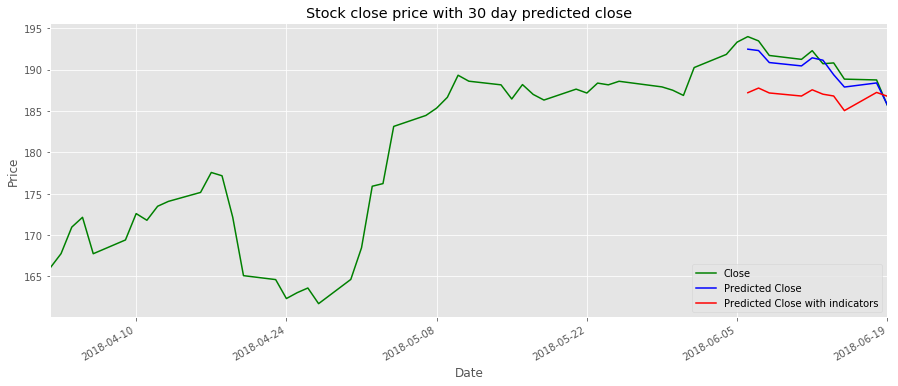

In [22]:
df['20180401':pd.to_datetime('today')]['close'].plot(figsize=(15,6), color="green", label='Close') 
result['Predicted'].plot(figsize=(15,6), color="blue", label='Predicted Close')
resultInd['Predicted'].plot(figsize=(15,6), color="red", label='Predicted Close with indicators')

plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Stock close price with 30 day predicted close')
plt.show()

# Conclusion
It is amazing to see how machine learning can produce descent results with such little data.  Also, its no surprise that adding random features really did not add much to the model (possibly just added a lot of noise).